## 1. 데이터 준비

In [1]:
%matplotlib inline
# Standard library imports
import datetime
from datetime import datetime
import os
from copy import deepcopy
import pickle

# Third-party libraries imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import seaborn as sns
import random
from itertools import combinations

# from IPython.display import clear_output
from scipy.spatial import distance
from sklearn.decomposition import PCA

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import datasets, transforms

# Local application/library specific imports
from data_utils import (generate_server_idcs, CustomSubset, split_3class_unbalanced, split_contain_multiclass,
                        split_7plus3class_unbalanced, CombinedCustomSubset)
from fl_devices import Server, Client
from helper import ExperimentLogger, display_train_stats
from models import ConvNet, Representation, Ten_class_classifier, Four_class_classifier


torch.manual_seed(42)
np.random.seed(42)

In [2]:
LOCAL_EPOCHS = 25
N_CLIENTS = 6
NUMBER_OF_CLUSTER = 3
ALPHA = 0.1
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# data = datasets.CIFAR10(root="CIFAR10/", download=True)
data = datasets.MNIST(root="MNIST/", download=False)
idcs = np.random.permutation(len(data))

def cluster(server, clients, number_of_cluster):
    label_predicted = pd.DataFrame()
    # label_acc = pd.DataFrame()
    for i, client in enumerate(clients):
        pred = server.check_cluster(client.model)
        # print(f'pred: {pred}')
        label_predicted = pd.concat([label_predicted, pd.DataFrame(pred, index=[i])])
        # label_acc = pd.concat([label_acc, pd.DataFrame(acc, index=[i])])
    label_predicted.reset_index(drop=True, inplace=True)
    label_predicted.fillna(0, inplace=True)
    
    print(f'predicted label')
    print(label_predicted)

    cluster_idcs, number_of_cluster= server.cluster_clients(label_predicted)
    return label_predicted, cluster_idcs, number_of_cluster



def get_cluster_averages(df, cluster_idcs):
    cluster_averages = {}

    for i, cluster in enumerate(cluster_idcs):
        cluster_data = df.loc[cluster, :]
        cluster_average = cluster_data.mean()
        cluster_averages[i] = cluster_average

    cluster_averages_df = pd.DataFrame(cluster_averages).T

    # calculate percentage for each value in a row
    cluster_percentages_df = cluster_averages_df.div(cluster_averages_df.sum(axis=1), axis=0).multiply(100)

    # apply threshold and rounding
    cluster_percentages_df = cluster_percentages_df.where(cluster_percentages_df >= 5, 0).round()

    return cluster_percentages_df / 10


def get_cluster_weights(cluster_logits, cluster_weight_per_class):
    # Step 1: Find the class with the maximum value in each logit in cluster_logits
    # Assuming the dimension for classes is the second one
    max_classes = [torch.argmax(logit, dim=1) for logit in cluster_logits]
    
    print(max_classes)
    cluster_weights = []
    #c luster별로 
    for i, iogits in enumerate(cluster_logits):
        weights = []
        for j, logit in enumerate(logits):
            
            # print(f'max_classes: {max_classes[i][j]}')
            # print("Shape of cluster_weight_per_class[{}]: ".format(i), cluster_weight_per_class[i].shape)
            weights.append(max_classes[i][j])
        print(weights)
        cluster_weights.append(weights)

def visualize_clusters(label_predicted, real_cluster_distribution):
    # Reduce the dimension of the data
    pca = PCA(n_components=2)
    label_predicted_pca = pca.fit_transform(label_predicted)
    
    # Define colors for the clusters
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    # Calculate the number of samples in each real cluster
    n_samples = len(label_predicted)
    real_cluster_sizes = [int(n_samples * dist) for dist in real_cluster_distribution]

    # Plot the clusters
    plt.figure(figsize=(8, 5))

    start_idx = 0  # To keep track of the start index of each real cluster
    for i, size in enumerate(real_cluster_sizes):
        end_idx = start_idx + size  # Calculate the end index for this real cluster
        color = colors[i % len(colors)]  # Determine the color for this real cluster

        # Scatter plot for points belonging to this real cluster
        for j in range(start_idx, end_idx):
            plt.scatter(label_predicted_pca[j, 0], label_predicted_pca[j, 1], c=color, s=50, label=f'Group {i+1}' if j == start_idx else "")

        start_idx = end_idx  # Update the start index for the next real cluster
    
    # Remove duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize='xx-large')

    # Remove x and y ticks
    plt.xticks([])
    plt.yticks([])

    # Save the figure with narrow margins
    plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
    current_time = datetime.now().strftime('%Y%m%d%H%M%S')
    plt.savefig(f'Figures/cluster_visualization_{current_time}.png', dpi=300, format='png')

    
    plt.show()



#     # Print the real cluster distribution
#     print("Real cluster distribution:", real_cluster_distribution)

#     # Calculate and print each client's cluster identity based on the real_cluster_distribution
#     n_clients = len(label_predicted)
#     cumulative_distribution = [0] + [sum(real_cluster_distribution[:i+1]) for i in range(len(real_cluster_distribution))]
#     client_cluster_id_real = [next((i for i, val in enumerate(cumulative_distribution) if val > client_idx / n_clients), -1) - 1 for client_idx in range(n_clients)]

#     print("Real cluster identity for each client:", client_cluster_id_real)

#     # Print each client's cluster identity based on the clusters argument
#     client_cluster_id_predicted = [next((i for i, cluster in enumerate(clusters) if client_idx in cluster), -1) for client_idx in range(n_clients)]
#     print("Predicted cluster identity for each client:", client_cluster_id_predicted)




def test_acc(server, clients, cluster_distribution):
    
    # Get individual client accuracies
    acc_clients = [client.evaluate() for client in clients]

    # Compute the average accuracy for each client
    client_acc = round(sum(acc_clients) / len(acc_clients), 3) if len(acc_clients) > 0 else 0

    # Compute cluster accuracies for this iteration
    cluster_accs_iteration = []
    start_idx = 0
    for distribution in cluster_distribution:
        end_idx = start_idx + int(distribution * len(clients))
        cluster_acc = round(sum(acc_clients[start_idx:end_idx]) / (end_idx - start_idx) + 0.000001, 3)
        cluster_accs_iteration.append(cluster_acc)
        start_idx = end_idx

    # Compute global accuracy for this iteration
    accuracies = [server.evaluate_distil(client.classifier) for client in clients]
    global_acc = round(np.mean(accuracies), 3)
    
    return client_acc, cluster_accs_iteration, global_acc


def get_global_logits(client_logits):
    avg_logits = torch.mean(torch.stack(client_logits), dim=0)
    return avg_logits

# def get_cluster_logits(client_logits, cluster_idcs):
#     cluster_logits = []
#     for i, cluster in enumerate(cluster_idcs):
#         cluster_client_logits = [client_logits[i] for i in cluster]
#         avg_cluster_logits = torch.mean(torch.stack(cluster_client_logits), dim=0)
#         cluster_logits.append(avg_cluster_logits)
#     return cluster_logits


def get_cluster_averages(df, cluster_idcs):
    cluster_averages = {}

    for i, cluster in enumerate(cluster_idcs):
        cluster_data = df.loc[cluster, :]
        cluster_average = cluster_data.mean()
        cluster_averages[i] = cluster_average

    cluster_averages_df = pd.DataFrame(cluster_averages).T

    # calculate percentage for each value in a row
    cluster_percentages_df = cluster_averages_df.div(cluster_averages_df.sum(axis=1), axis=0).multiply(100)

    # apply threshold and rounding
    cluster_percentages_df = cluster_percentages_df.where(cluster_percentages_df >= 5, 0).round()

    return cluster_percentages_df / 10

def compute_accuracy(global_logits, data_targets, server_idcs):
    """
    Compute accuracy of predictions based on global logits.

    Args:
    - global_logits (list of Tensors): Each Tensor represents the logits for a data instance, 
                                       and its size is the number of classes.
    - data_targets (list of ints): List of true labels for all data.
    - server_idcs (list of ints): Indices of data instances we're interested in.

    Returns:
    - accuracy (float): Computed accuracy.
    """
    true_labels = [data_targets[i] for i in server_idcs]
    
    correct_predictions = 0
    total_predictions = len(true_labels)

    for logits, label in zip(global_logits, true_labels):
        predicted_label = np.argmax(logits.cpu().numpy())  # Convert Tensor to numpy and get index of max value
        if predicted_label == label:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy


def save_tensor_to_csv(tensor, filename):
    # Convert tensor to numpy array
    array = tensor.cpu().detach().numpy()
    
    # Save numpy array to CSV file
    np.savetxt(filename, array, delimiter=",")

# def get_cluster_weights(cluster_logits, cluster_weight_per_class):
#     # Step 1: Find the class with the maximum value in each logit in cluster_logits
#     # Assuming the dimension for classes is the second one
#     max_classes = [torch.argmax(logit, dim=1) for logit in cluster_logits]
    
#     print(max_classes)
#     cluster_weights = []
#     #c luster별로 
#     for i, iogits in enumerate(cluster_logits):
#         weights = []
#         for j, logit in enumerate(logits):
            
#             # print(f'max_classes: {max_classes[i][j]}')
#             # print("Shape of cluster_weight_per_class[{}]: ".format(i), cluster_weight_per_class[i].shape)
#             weights.append(max_classes[i][j])
#         print(weights)
#         cluster_weights.append(weights)


In [4]:
def make_global_logit(n_clients, total_client_data, distill_data, number_of_cluster, cluster_distribution, instance_per_class, instance_per_minor_class, instances_per_class_per_client):
    data_per_class=int(distill_data//10)
    train_idcs, test_idcs = idcs[:total_client_data], idcs[total_client_data:(total_client_data + int(distill_data * 2))]
    train_labels = data.targets
    test_labels = data.targets
    server_idcs = generate_server_idcs(test_idcs, test_labels, int(distill_data//10))
    print(f'sever idcs: {len(server_idcs)}')
    client_idcs, _ = split_7plus3class_unbalanced(train_idcs, train_labels, n_clients, cluster_distribution, instance_per_class, instance_per_minor_class)
    #client_idcs = split_contain_multiclass(train_idcs, train_labels, n_clients, instance_per_class, instances_per_class_per_client, cluster_distribution)
    
    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, server_idcs, transforms.Compose([transforms.ToTensor()]))
    print(f'test_data: {len(test_data)}')
    
    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(ConvNet, lambda x : torch.optim.Adam(x),test_data)

    clients = [Client(Representation, dat, i) 
           for i, dat in enumerate(client_data) if len(dat) > 20]
    
    # print(f'client count: {len(clients)}')

    client_logits = []
    
        
    # 1. Train classifier
    for i, client in enumerate(clients):
        client.classifier = Ten_class_classifier(client.model).to(device)
        client.train_classifier(lr=1e-3)

    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    # 2. get client loigt
    for i, client in enumerate(clients):
        client_logits.append(server.get_clients_logit(client.classifier))

    # 3. make global logit
    global_logits = server.get_global_logits(client_logits)
    accuracy = compute_accuracy(global_logits, test_labels, server_idcs)
    
    print(f"Global Logit's Accuracy: {accuracy * 100:.2f}%")
    
    return server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution, client_acc, cluster_accs, global_acc

def distill_with_cluster_logit(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution, t):
    cluster_logits,  cluster_idcs, label_predicted = server.get_cluster_logits(client_logits, number_of_cluster, t)
    visualize_clusters(label_predicted, cluster_distribution)
    silhouette, ari = server.evaluate_clustering(label_predicted, cluster_distribution, cluster_idcs)
    
    print(f'silhouette: {silhouette}, ari: {ari}')

    cluster_distill_loaders = []
    
    for cluster_logit in cluster_logits:
        distill_loader = server.create_distill_loader(data, server_idcs, cluster_logit)
        cluster_distill_loaders.append(distill_loader)
        
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        
        cluster_idx = next(j for j, cluster in enumerate(cluster_idcs) if i in cluster)
        
        client.distill((cluster_distill_loaders[cluster_idx]))
    
    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    return client_acc, cluster_accs, global_acc, silhouette, ari


def get_cluster_acc(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution, t):
    cluster_logits,  cluster_idcs, label_predicted = server.get_cluster_logits(client_logits, number_of_cluster, t)
    visualize_clusters(label_predicted, cluster_distribution)
    silhouette, ari = server.evaluate_clustering(label_predicted, cluster_distribution, cluster_idcs)
    
    print(f'silhouette: {silhouette}, ari: {ari}')
    return silhouette, ari


def distill_with_global_logit(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution):
    distill_loader = server.create_distill_loader(data, server_idcs, global_logits)
    
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        client.distill(distill_loader)
    
    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    return client_acc, cluster_accs, global_acc

def copy_classifiers(clients):
    classifiers_state = []
    for client in clients:
        classifier_state = client.classifier.state_dict()
        classifiers_state.append(classifier_state)
    return classifiers_state


In [5]:
def cluster_train_result_exp(n_clients, total_client_data, distill_data, number_of_cluster, cluster_distribution, instance_per_class, instance_per_minor_class, classinstances_per_class_per_client, t):
   
    client_accs = []
    cluster_accs = []
    global_accs = []
    
    (
        server, clients, client_logits, global_logits,
        number_of_cluster, server_idcs, cluster_distribution,
        new_client_acc, new_cluster_accs, new_global_acc
    ) = make_global_logit(
        n_clients, total_client_data, distill_data,
        number_of_cluster, cluster_distribution,
        instance_per_class, instance_per_minor_class, instances_per_class_per_client
    )

    
    print(f'acc before distill: {new_client_acc}, {new_cluster_accs}, {new_global_acc}')
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)

    classifiers_state = copy_classifiers(clients)
    
    new_client_acc, new_cluster_accs, new_global_acc, silhouette, ari = distill_with_cluster_logit(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution, t)
    
    
    for i, client in enumerate(clients):
        client.classifier.load_state_dict(classifiers_state[i])
    
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)
    
    new_client_acc, new_cluster_accs, new_global_acc = distill_with_global_logit(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution)
   
    
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)
    
    print(f'acc after global distill: {client_accs[1]}, {cluster_accs[1]}, {global_accs[1]}')
    print(f'acc after cluster distill: {client_accs[-1]}, {cluster_accs[-1]}, {global_accs[-1]}')
    return client_accs, cluster_accs, global_accs, silhouette, ari

def clustering_exp(n_clients, total_client_data, distill_data, number_of_cluster, cluster_distribution, instance_per_class, instance_per_minor_class, instances_per_class_per_client, t):
   
    client_accs = []
    cluster_accs = []
    global_accs = []
    
    (
        server, clients, client_logits, global_logits,
        number_of_cluster, server_idcs, cluster_distribution,
        new_client_acc, new_cluster_accs, new_global_acc
    ) = make_global_logit(
        n_clients, total_client_data, distill_data,
        number_of_cluster, cluster_distribution,
        instance_per_class, instance_per_minor_class, instances_per_class_per_client
    )

    
    print(f'acc before distill: {new_client_acc}, {new_cluster_accs}, {new_global_acc}')
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)

    classifiers_state = copy_classifiers(clients)
    
    sil, ari = get_cluster_acc(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution, t)
    return sil, ari


def get_combination(array_length, class_per_cluster):
    if class_per_cluster == 1:
        combinations = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
    elif class_per_cluster == 2:
        combinations = [[0,1], [2,3], [4,5], [6,7], [8,9], [0,5], [1,6], [2,7], [3,8], [4,9], [0,3], [1,4], [2,5], [6,8], [7,9], [0,4], [1,5], [2,9], [3,7], [8,6]]
    elif class_per_cluster == 3:
        combinations = [[0,1,2], [3,4,5], [6,7,8], [9,0,1], [2,3,4], [5,6,7], [8,9,0], [1,2,3], [4,5,6], [7,8,9]]
    elif class_per_cluster == 4:
        combinations = [[0,1,2,3],[4,5,6,7],[8,9,0,1],[2,3,4,5],[6,7,8,9],[2,4,6,8],[1,3,5,9],[0,3,6,9],[1,4,7,0],[2,5,8,1]]
    elif class_per_cluster == 5:
        combinations = [[0,1,2,3,4],[4,5,6,7,8],[8,9,0,1,2],[2,3,4,5,6],[6,7,8,9,0],[2,4,6,8,0],[1,3,5,7,9],[0,2,3,6,9],[1,4,6,7,0],[2,5,6,8,1]]
    else:
        return "Invalid class_per_cluster"
    
    return combinations[:array_length]


In [6]:
def model_clustering_exp(n_clients, total_client_data, distill_data, number_of_cluster, cluster_distribution, instance_per_class, instances_per_class_per_client):
    print(f'number_of_cluster: {number_of_cluster}')
    data_per_class=int(distill_data//10)
    train_idcs, test_idcs = idcs[:total_client_data], idcs[total_client_data:(total_client_data + int(distill_data * 2))]
    train_labels = data.targets
    test_labels = data.targets
    
    server_idcs = generate_server_idcs(test_idcs, test_labels, int(distill_data//10))

    # client_idcs = split_noniid(train_idcs, train_labels, alpha=alpha, n_clients=N_CLIENTS)
    client_idcs = split_contain_multiclass(train_idcs, train_labels, n_clients, instance_per_class, instances_per_class_per_client)
    
    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, server_idcs, transforms.Compose([transforms.ToTensor()]))

    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(Representation, lambda x : torch.optim.Adam(x),test_data)

    clients = [Client(Representation, dat, i) for i, dat in enumerate(client_data) if len(dat) > 20]
    

    # 1. Train classifier
    for i, client in enumerate(clients):
        client.train_classifier(lr=1e-3)

    similarities = server.compute_pairwise_similarities(clients)
    # print('similarities')
    # print(type(similarities))
    # print(similarities)
    cluster_idcs = server.cluster_clients_KMeans(similarities, number_of_cluster)
    
    visualize_clusters(similarities, cluster_distribution)
    silhouette, ari = server.evaluate_clustering(similarities, cluster_distribution, cluster_idcs)
    print(f'silhouette: {silhouette}, ari: {ari}')
    return silhouette, ari

sever idcs: 4000
data_per_class_3: 158, data_per_class_7: 4
test_data: 4000
Global Logit's Accuracy: 78.50%
acc before distill: 0.921, [0.936, 0.882, 0.944], 0.397
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]


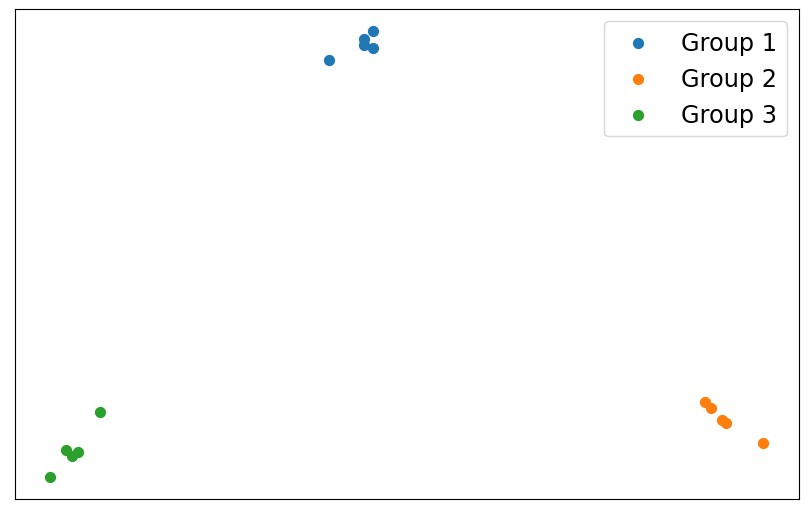

predicted_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.8217637538909912, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
acc after global distill: 0.94, [0.94, 0.935, 0.943], 0.382
acc after cluster distill: 0.878, [0.909, 0.821, 0.903], 0.964
sever idcs: 4000
data_per_class_3: 150, data_per_class_7: 7
test_data: 4000
Global Logit's Accuracy: 80.15%
acc before distill: 0.876, [0.9, 0.824, 0.904], 0.53
[1 1 1 1 1 0 0 0 0 0 2 2 2 2 2]


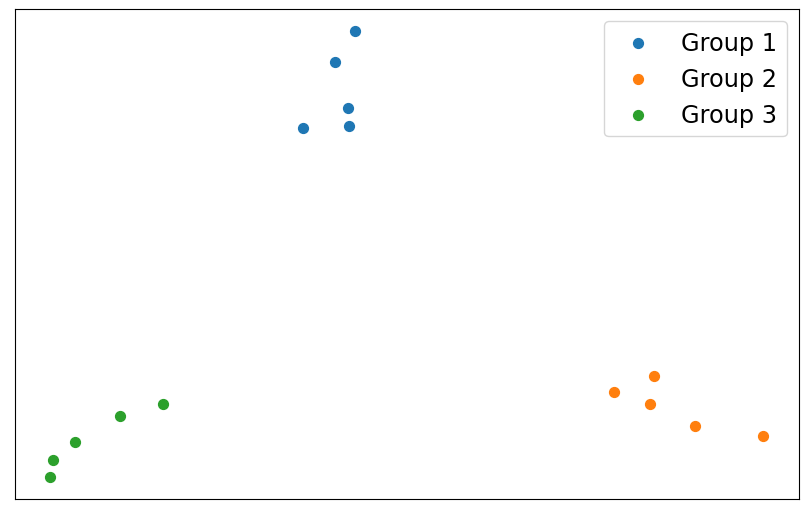

predicted_labels: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.6782925724983215, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
acc after global distill: 0.902, [0.909, 0.889, 0.907], 0.479
acc after cluster distill: 0.879, [0.904, 0.839, 0.895], 0.969
sever idcs: 4000
data_per_class_3: 133, data_per_class_7: 14
test_data: 4000
Global Logit's Accuracy: 86.33%
acc before distill: 0.875, [0.885, 0.869, 0.871], 0.856
[2 2 2 2 2 1 1 1 1 1 0 0 0 0 0]


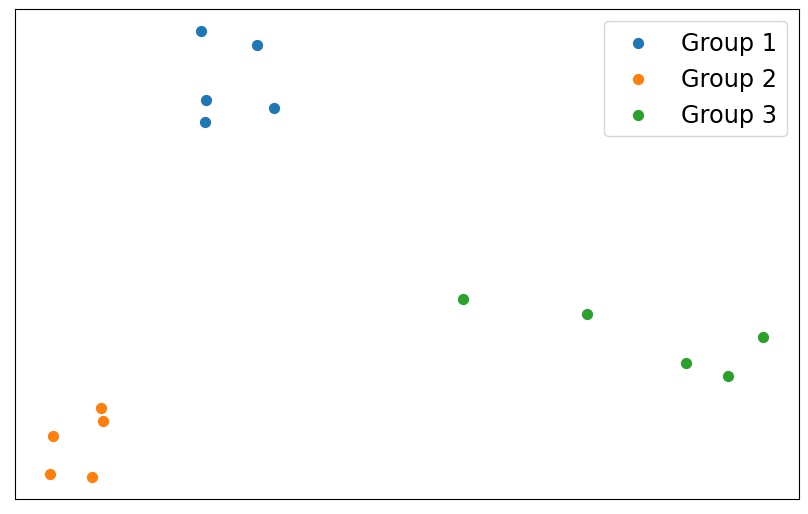

predicted_labels: [2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.6132561564445496, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
acc after global distill: 0.905, [0.903, 0.908, 0.904], 0.893
acc after cluster distill: 0.905, [0.919, 0.901, 0.896], 0.962
sever idcs: 4000
data_per_class_3: 117, data_per_class_7: 21
test_data: 4000
Global Logit's Accuracy: 88.78%
acc before distill: 0.863, [0.859, 0.852, 0.879], 0.918
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]


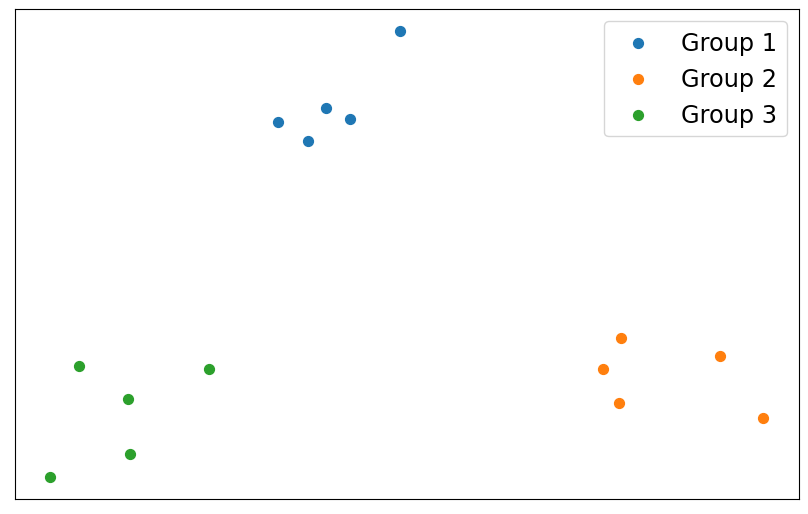

predicted_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.6051514148712158, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
acc after global distill: 0.9, [0.896, 0.891, 0.912], 0.939
acc after cluster distill: 0.9, [0.911, 0.876, 0.912], 0.971
sever idcs: 4000
data_per_class_3: 100, data_per_class_7: 29
test_data: 4000
Global Logit's Accuracy: 88.62%
acc before distill: 0.853, [0.85, 0.86, 0.849], 0.917
[1 1 1 1 1 0 0 0 0 0 2 2 2 2 2]


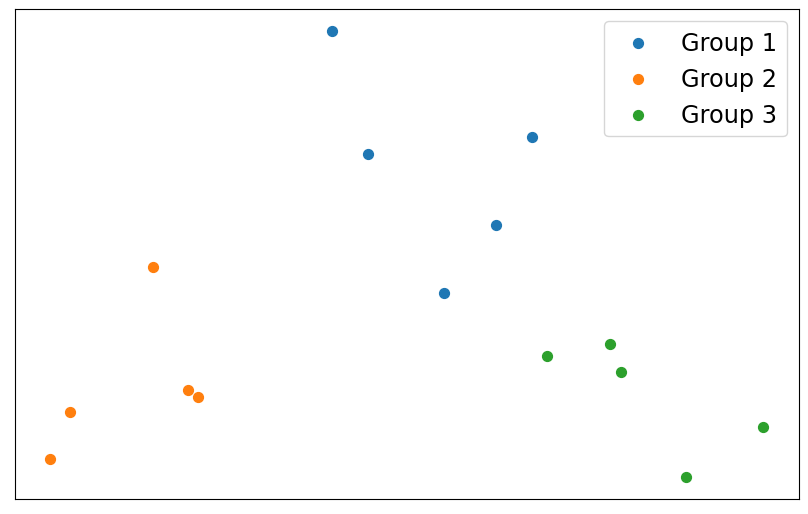

predicted_labels: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.3870180547237396, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
acc after global distill: 0.896, [0.899, 0.887, 0.902], 0.943
acc after cluster distill: 0.905, [0.91, 0.898, 0.907], 0.959
sever idcs: 4000
data_per_class_3: 84, data_per_class_7: 36
test_data: 4000
Global Logit's Accuracy: 89.08%
acc before distill: 0.852, [0.857, 0.842, 0.858], 0.932
[2 2 1 0 0 0 0 0 0 0 1 1 1 1 1]


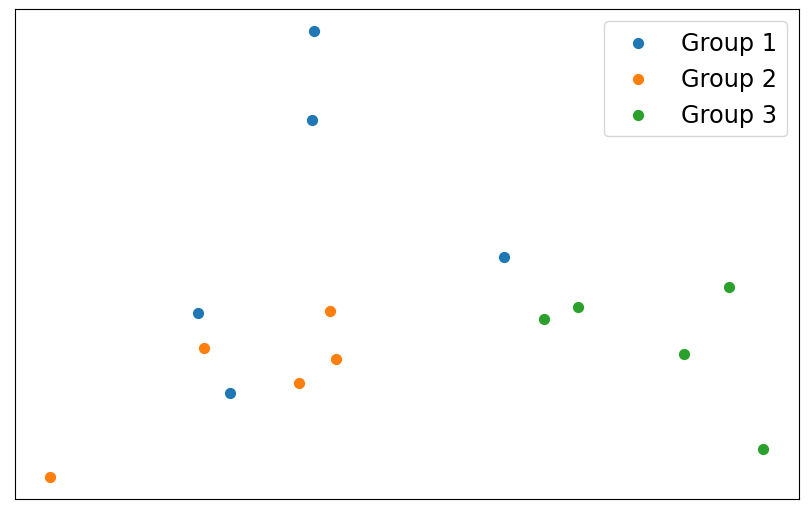

predicted_labels: [2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
true_labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
silhouette: 0.3386051058769226, ari: 0.4984423676012461
client 0 distill
client 10 distill
client 0 distill
client 10 distill
acc after global distill: 0.902, [0.9, 0.903, 0.903], 0.953
acc after cluster distill: 0.917, [0.914, 0.914, 0.921], 0.959


In [7]:
import pandas as pd

# Initialize empty DataFrame to store results with simplified columns
minor_class_ratios = [5, 10, 20, 30, 40, 50]
cluster_distribution = [1/3, 1/3, 1/3]
clustering_acc = pd.DataFrame(columns=['silhouette', 'ari'], index=minor_class_ratios)
client_acc = pd.DataFrame(columns=['before_distill', 'global_distill', 'cluster_distill'], index=minor_class_ratios)
cluster_acc = pd.DataFrame(columns=['before_distill', 'global_distill', 'cluster_distill'], index=minor_class_ratios)

cluster_count = 3
t = 2

instance_per_classes = [158, 150, 133, 117, 100, 84]
instance_per_minor_classes = [4, 7, 14, 21, 29, 36]


# Iterate over different minor_class_ratios, instance_per_classes, and instance_per_minor_classes values
for minor_class_ratio, instance_per_class, instance_per_minor_class in zip(minor_class_ratios, instance_per_classes, instance_per_minor_classes):
    n_clients = cluster_count * 5
    instances_per_class_per_client = get_combination(cluster_count, 3)
    
    # Replace with your actual clustering_exp function
    # Assume it accepts t as a parameter
    client_accs, cluster_accs, global_accs, silhouette, ari = cluster_train_result_exp(
            n_clients, 40000, 4000, cluster_count, cluster_distribution, instance_per_class, instance_per_minor_class, instances_per_class_per_client, t
    )
    
    # Update DataFrame
    clustering_acc.loc[minor_class_ratio, 'silhouette'] = silhouette
    clustering_acc.loc[minor_class_ratio, 'ari'] = ari
    
    client_acc.loc[minor_class_ratio, 'before_distill'] = client_accs[0]
    client_acc.loc[minor_class_ratio, 'cluster_distill'] = client_accs[1]
    client_acc.loc[minor_class_ratio, 'global_distill'] = client_accs[2]
    
    cluster_acc.loc[minor_class_ratio, 'before_distill'] = cluster_accs[0]
    cluster_acc.loc[minor_class_ratio, 'cluster_distill'] = cluster_accs[1]
    cluster_acc.loc[minor_class_ratio, 'global_distill'] = cluster_accs[2]

In [8]:
clustering_acc

,silhouette,ari
5,0.821764,1.0
10,0.678293,1.0
20,0.613256,1.0
30,0.605151,1.0
40,0.387018,1.0
50,0.338605,0.498442


In [9]:
client_acc

,before_distill,global_distill,cluster_distill
5,0.921,0.878,0.94
10,0.876,0.879,0.902
20,0.875,0.905,0.905
30,0.863,0.9,0.9
40,0.853,0.905,0.896
50,0.852,0.917,0.902


In [10]:
cluster_acc

,before_distill,global_distill,cluster_distill
5,"[0.936, 0.882, 0.944]","[0.909, 0.821, 0.903]","[0.94, 0.935, 0.943]"
10,"[0.9, 0.824, 0.904]","[0.904, 0.839, 0.895]","[0.909, 0.889, 0.907]"
20,"[0.885, 0.869, 0.871]","[0.919, 0.901, 0.896]","[0.903, 0.908, 0.904]"
30,"[0.859, 0.852, 0.879]","[0.911, 0.876, 0.912]","[0.896, 0.891, 0.912]"
40,"[0.85, 0.86, 0.849]","[0.91, 0.898, 0.907]","[0.899, 0.887, 0.902]"
50,"[0.857, 0.842, 0.858]","[0.914, 0.914, 0.921]","[0.9, 0.903, 0.903]"


In [11]:
def get_combination_new(type):
    if type == 1:
        combinations = [range(10), [0, 1, 2], [3, 4, 5], [6, 7, 8]]
    elif type == 2:
        combinations = [range(10), [0, 1, 2, 3, 4], [8, 9, 5], [6, 7]]
    elif type == 3:
        combinations = [range(10), [0, 1, 2, 8], [3, 4], [6, 7]]
    elif type == 4:
        combinations = [range(10), [0, 1], [3, 4], [6, 7]]
    return combinations

# Initialize empty DataFrame to store results with simplified columns
types = [1, 2, 3, 4]
cluster_distribution = [1/3, 1/3, 1/3]
clustering_acc = pd.DataFrame(columns=['silhouette', 'ari'], index=types)
client_acc = pd.DataFrame(columns=['before_distill', 'global_distill', 'cluster_distill'], index=types)
cluster_acc = pd.DataFrame(columns=['before_distill', 'global_distill', 'cluster_distill'], index=types)

cluster_count = 3
t = 2

# For simplicity, let's use some default values for instance_per_class and instance_per_minor_class
# You can modify these within your loop based on each type if they vary
instance_per_class = 50
instance_per_minor_class = 0

# Iterate over different types
for type_ in types:
    n_clients = cluster_count * 5
    instances_per_class_per_client = get_combination(cluster_count, 3)
    
    # Replace with your actual clustering_exp function
    # Assume it accepts t as a parameter
    client_accs, cluster_accs, global_accs, silhouette, ari = cluster_train_result_exp(
            n_clients, 40000, 4000, cluster_count, cluster_distribution, 50, instances_per_class_per_client, t
    )
    
    # Update DataFrame
    clustering_acc.loc[type_, 'silhouette'] = silhouette
    clustering_acc.loc[type_, 'ari'] = ari
    
    client_acc.loc[type_, 'before_distill'] = client_accs[0]
    client_acc.loc[type_, 'cluster_distill'] = client_accs[1]
    client_acc.loc[type_, 'global_distill'] = client_accs[2]
    
    cluster_acc.loc[type_, 'before_distill'] = cluster_accs[0]
    cluster_acc.loc[type_, 'cluster_distill'] = cluster_accs[1]
    cluster_acc.loc[type_, 'global_distill'] = cluster_accs[2]
